# ML-Modelle auf dem Vergleichdatensatz trainieren

### Benötigte Pakete importieren und Einstellungen setzen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Bereinigte Ticketdaten einlesen und erkunden

In [3]:
finance_ticket_df = pd.read_excel('finance_tickets_cleaned_with_topics.xlsx')
finance_ticket_df.head(5)

,Unnamed: 0,Meldung,Ticketart,Meldung_cleaned,Meldung_BERT,Länge,Meldung_lemmatized
0,0,Good morning my name is XXXX XXXX and I apprec...,0,good morning name appreciate could help put st...,good morning my name is and appreciate it if y...,75,good morning name appreciate could help put st...
1,1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1,upgraded card told agent upgrade anniversary d...,i upgraded my card in and was told by the agen...,56,upgrade card tell agent upgrade anniversary da...
2,2,Chase Card was reported on XX/XX/2019. However...,1,chase card reported however fraudulent applica...,chase card was reported on however fraudulent ...,31,chase card report however fraudulent applicati...
3,3,"On XX/XX/2018, while trying to book a XXXX XX...",1,trying book ticket came across offer applied t...,on while trying to book ticket came across an ...,240,try book ticket come across offer apply toward...
4,4,my grand son give me check for {$1600.00} i de...,0,grand son give check deposit chase account fun...,my grand son give me check for deposit it into...,88,grand son give check deposit chase account fun...


In [4]:
ticket_df = finance_ticket_df[['Meldung', 'Meldung_lemmatized', 'Ticketart']].copy()
ticket_df.rename(columns={'Ticketart': 'Klasse'}, inplace=True)
ticket_df

,Meldung,Meldung_lemmatized,Klasse
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade card tell agent upgrade anniversary da...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply toward...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,0
...,...,...,...
19217,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,1
19218,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday call chas visa credit card provider ...,3
19219,I am not familiar with XXXX pay and did not un...,familiar pay understand great risk provide con...,3
19220,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs chase credit card chase fr...,4


### Klassen numerische Werte zuordnen und Klassenverteilung darstellen

In [5]:
ticket_df['Klasse'].value_counts()

0    4888
1    4802
3    4131
2    3295
4    2106
Name: Klasse, dtype: int64

In [6]:
mapping_classes = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}
ticket_df['Ticketart'] = ticket_df['Klasse'].map(mapping_classes)
ticket_df['Ticketart'].value_counts()

Bank Account services          4888
Credit card or prepaid card    4802
Theft/Dispute Reporting        4131
Others                         3295
Mortgage/Loan                  2106
Name: Ticketart, dtype: int64

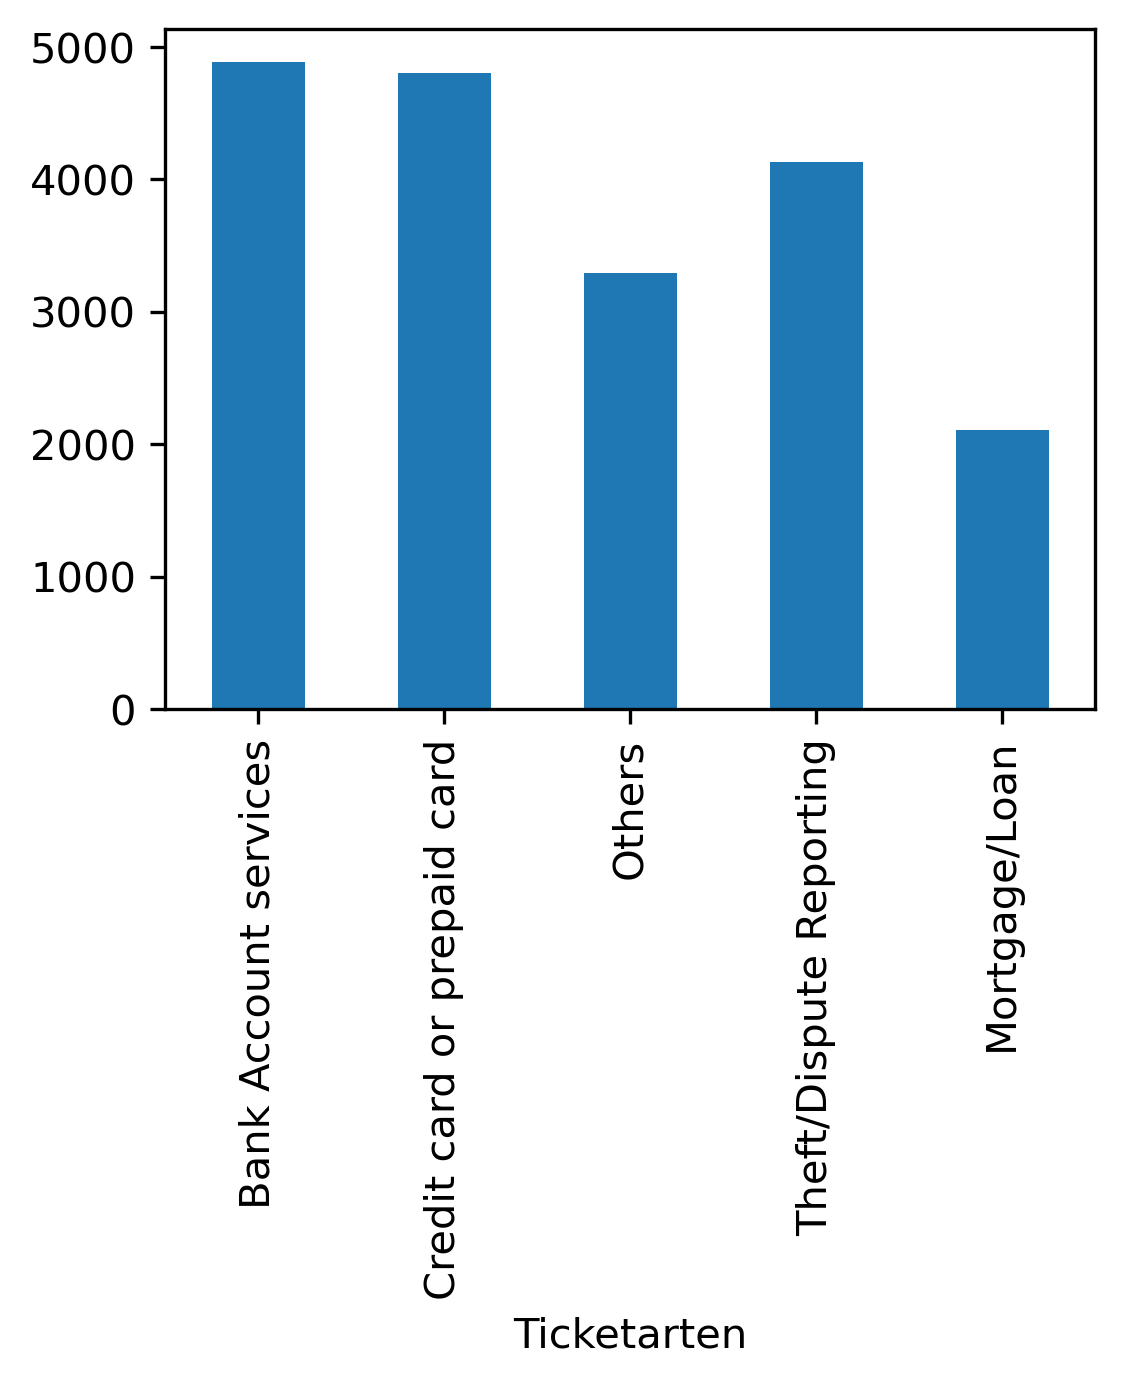

In [7]:
fig, ax = plt.subplots(figsize=(4,3))
ticket_df.groupby('Klasse').Meldung_lemmatized.count().plot.bar(ylim=0)
plt.xlabel('Ticketarten')
ax.set_xticklabels(['Bank Account services', 'Credit card or prepaid card', 'Others', 'Theft/Dispute Reporting', 'Mortgage/Loan'])
plt.show()

### Initialisierung der Listen, in welchen die benötigten Werte gespeichert werden

In [8]:
training_times = []

accuracies = []

balanced_accuracies = []

f1_scores_macro = []
f1_scores_weighted = []

### Baseline-Modell trainieren, Vorhersagen treffen und Evaluierungswerte speichern (auf unbereinigten Ticketmeldungen)

In [9]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(ticket_df['Meldung'], ticket_df['Klasse'], random_state = 24)

In [10]:
count_vect_baseline = CountVectorizer()
X_train_counts_baseline = count_vect_baseline.fit_transform(X_train_baseline.values.astype('U'))
X_test_counts_baseline = count_vect_baseline.transform(X_test_baseline.values.astype('U'))

In [11]:
tfidf_transformer_baseline = TfidfTransformer()
X_train_tfidf_baseline = tfidf_transformer_baseline.fit_transform(X_train_counts_baseline)
X_test_tfidf_baseline = tfidf_transformer_baseline.transform(X_test_counts_baseline)

In [12]:
start_time_baseline = time.time()
ticket_clf_baseline = MultinomialNB().fit(X_train_tfidf_baseline, y_train_baseline)
end_time_baseline = time.time()
training_time_baseline = round(end_time_baseline - start_time_baseline, 2)

In [13]:
y_pred_baseline = ticket_clf_baseline.predict(X_test_tfidf_baseline)

In [14]:
print(training_time_baseline)
training_times.append(training_time_baseline)

accuracy_baseline = round(accuracy_score(y_test_baseline, y_pred_baseline), 2)
print(accuracy_baseline)
accuracies.append(accuracy_baseline)

balanced_accuracy_baseline = round(balanced_accuracy_score(y_test_baseline, y_pred_baseline), 2)
print(balanced_accuracy_baseline)
balanced_accuracies.append(balanced_accuracy_baseline)

f1_score_macro_baseline = round(f1_score(y_test_baseline, y_pred_baseline, average='macro'), 2)
print(f1_score_macro_baseline)
f1_scores_macro.append(f1_score_macro_baseline)

f1_score_weighted_baseline = round(f1_score(y_test_baseline, y_pred_baseline, average='weighted'), 2)
print(f1_score_weighted_baseline)
f1_scores_weighted.append(f1_score_weighted_baseline)

0.02
0.71
0.63
0.61
0.67


### Textrepräsentation durch TF-IDF (der bereinigten und lemmatisierten Ticketmeldungen) und Merkmalsauswahl mit Chi-Quadrat-Methode

In [15]:
tfidf = TfidfVectorizer(lowercase=False, analyzer='word', sublinear_tf=True, min_df=2, norm='l2', ngram_range=(1, 3))
features = tfidf.fit_transform(ticket_df['Meldung_lemmatized'].values.astype('U'))
labels = ticket_df.Klasse

In [16]:
tickettype_keys = ['Bank Account services', 'Credit card or prepaid card', 'Others', 'Theft/Dispute Reporting', 'Mortgage/Loan']
tickettype_ids = [0, 1, 2, 3, 4]
tickettype_dict = {tickettype_keys[i]: tickettype_ids[i] for i in range(len(tickettype_keys))}

N = 10
for tickettype_key, tickettype_id in sorted(tickettype_dict.items()):
    chi2_features = chi2(features, labels == tickettype_id)
    indices = np.argsort(chi2_features[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\033[1mTicketart {}:\033[0m".format(tickettype_key))
    print("Unigramme mit stärkster Korrelation:\n {}".format(', '.join(unigrams[-N:])))
    print("\n")
    print("Bigramme mit stärkster Korrelation:\n {}".format(', '.join(bigrams[-N:])))
    print("\n---\n")

Ticketart Bank Account services:
Unigramme mit stärkster Korrelation:
 atm, checking, credit, bank, account, branch, money, fund, check, deposit


Bigramme mit stärkster Korrelation:
 credit report, account chase, check deposit, credit card, checking account, saving account, bank account, direct deposit, deposit check, check account

---

Ticketart Credit card or prepaid card:
Unigramme mit stärkster Korrelation:
 apply, jpmcb, bureaus, reporting, score, hard, card, report, credit, inquiry


Bigramme mit stärkster Korrelation:
 jpmcb card, chase credit, credit limit, apply credit, credit reporting, credit score, inquiry credit, hard inquiry, credit card, credit report

---

Ticketart Mortgage/Loan:
Unigramme mit stärkster Korrelation:
 due, pay, make, principal, automatic, monthly, auto, minimum, late, payment


Bigramme mit stärkster Korrelation:
 payment would, automatic payment, payment receive, monthly payment, payment chase, minimum payment, payment due, payment make, late payment

### Train/Test Split

In [17]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, ticket_df.index, test_size=0.2, stratify=labels, random_state=24)

### MNB-Modell trainieren, Vorhersagen treffen und Evaluierungswerte speichern

In [18]:
start_time_mnb = time.time()
ticket_clf_mnb = MultinomialNB(alpha=0.1, fit_prior=False).fit(X_train, y_train)
end_time_mnb = time.time()
training_time_mnb = round(end_time_mnb - start_time_mnb, 2)

In [19]:
y_pred_mnb = ticket_clf_mnb.predict(X_test)

In [20]:
print(training_time_mnb)
training_times.append(training_time_mnb)

accuracy_mnb = round(accuracy_score(y_test, y_pred_mnb), 2)
print(accuracy_mnb)
accuracies.append(accuracy_mnb)

balanced_accuracy_mnb = round(balanced_accuracy_score(y_test, y_pred_mnb), 2)
print(balanced_accuracy_mnb)
balanced_accuracies.append(balanced_accuracy_mnb)

f1_score_macro_mnb = round(f1_score(y_test, y_pred_mnb, average='macro'), 2)
print(f1_score_macro_mnb)
f1_scores_macro.append(f1_score_macro_mnb)

f1_score_weighted_mnb = round(f1_score(y_test, y_pred_mnb, average='weighted'), 2)
print(f1_score_weighted_mnb)
f1_scores_weighted.append(f1_score_weighted_mnb)

0.07
0.82
0.8
0.81
0.82


### SVM-Modell trainieren, Vorhersagen treffen und Evaluierungswerte speichern

In [21]:
start_time_svm = time.time()
ticket_clf_svm = LinearSVC(class_weight='balanced').fit(X_train, y_train)
end_time_svm = time.time()
training_time_svm = round(end_time_svm - start_time_svm, 2)

In [22]:
y_pred_svm = ticket_clf_svm.predict(X_test)

In [23]:
print(training_time_svm)
training_times.append(training_time_svm)

accuracy_svm = round(accuracy_score(y_test, y_pred_svm), 2)
print(accuracy_svm)
accuracies.append(accuracy_svm)

balanced_accuracy_svm = round(balanced_accuracy_score(y_test, y_pred_svm), 2)
print(balanced_accuracy_svm)
balanced_accuracies.append(balanced_accuracy_svm)

f1_score_macro_svm = round(f1_score(y_test, y_pred_svm, average='macro'), 2)
print(f1_score_macro_svm)
f1_scores_macro.append(f1_score_macro_svm)

f1_score_weighted_svm = round(f1_score(y_test, y_pred_svm, average='weighted'), 2)
print(f1_score_weighted_svm)
f1_scores_weighted.append(f1_score_weighted_svm)

2.13
0.9
0.9
0.9
0.9


### Gespeicherte Evaluierungswerte des BERT-Modells auf dem Vergleichsdatensatz holen

In [24]:
with open('value_cache_bert_finance', 'r') as f:
    json_bert = json.load(f)
    
training_times.append(round(json_bert['training_time_bert'], 2))
accuracies.append(round(json_bert['accuracy_bert'], 2))
balanced_accuracies.append(round(json_bert['balanced_accuracy_bert'], 2))
f1_scores_macro.append(round(json_bert['f1_score_macro_bert'], 2))
f1_scores_weighted.append(round(json_bert['f1_score_weighted_bert'], 2))

### Evaluierungswerte der ML-Modelle auf dem Vergleichsdatensatz speichern

In [25]:
finance_values = {
    "training_times2": training_times,
    "accuracies2": accuracies,
    "balanced_accuracies2": balanced_accuracies,
    "f1_scores_macro2": f1_scores_macro,
    "f1_scores_weighted2": f1_scores_weighted
}

json_finance = json.dumps(finance_values)
    
with open('value_cache_finance', 'w') as f:
    f.write(json_finance)